Found 2771 result files
global_flow, 1 electrodes: Mean AUROC = 0.4993 ± 0.0017 (n=38)
global_flow, 4 electrodes: Mean AUROC = 0.4995 ± 0.0012 (n=58)
global_flow, 16 electrodes: Mean AUROC = 0.5042 ± 0.0012 (n=60)
global_flow, 64 electrodes: Mean AUROC = 0.5170 ± 0.0020 (n=60)
volume, 1 electrodes: Mean AUROC = 0.5094 ± 0.0022 (n=38)
volume, 4 electrodes: Mean AUROC = 0.5106 ± 0.0022 (n=58)
volume, 16 electrodes: Mean AUROC = 0.5191 ± 0.0021 (n=60)
volume, 64 electrodes: Mean AUROC = 0.5429 ± 0.0027 (n=60)
speech, 1 electrodes: Mean AUROC = 0.5053 ± 0.0018 (n=38)
speech, 4 electrodes: Mean AUROC = 0.5191 ± 0.0028 (n=58)
speech, 16 electrodes: Mean AUROC = 0.5398 ± 0.0043 (n=60)
speech, 64 electrodes: Mean AUROC = 0.5795 ± 0.0058 (n=60)
gpt2_surprisal, 1 electrodes: Mean AUROC = 0.5051 ± 0.0017 (n=38)
gpt2_surprisal, 4 electrodes: Mean AUROC = 0.5088 ± 0.0022 (n=58)
gpt2_surprisal, 16 electrodes: Mean AUROC = 0.5208 ± 0.0027 (n=60)
gpt2_surprisal, 64 electrodes: Mean AUROC = 0.5423 ± 0.

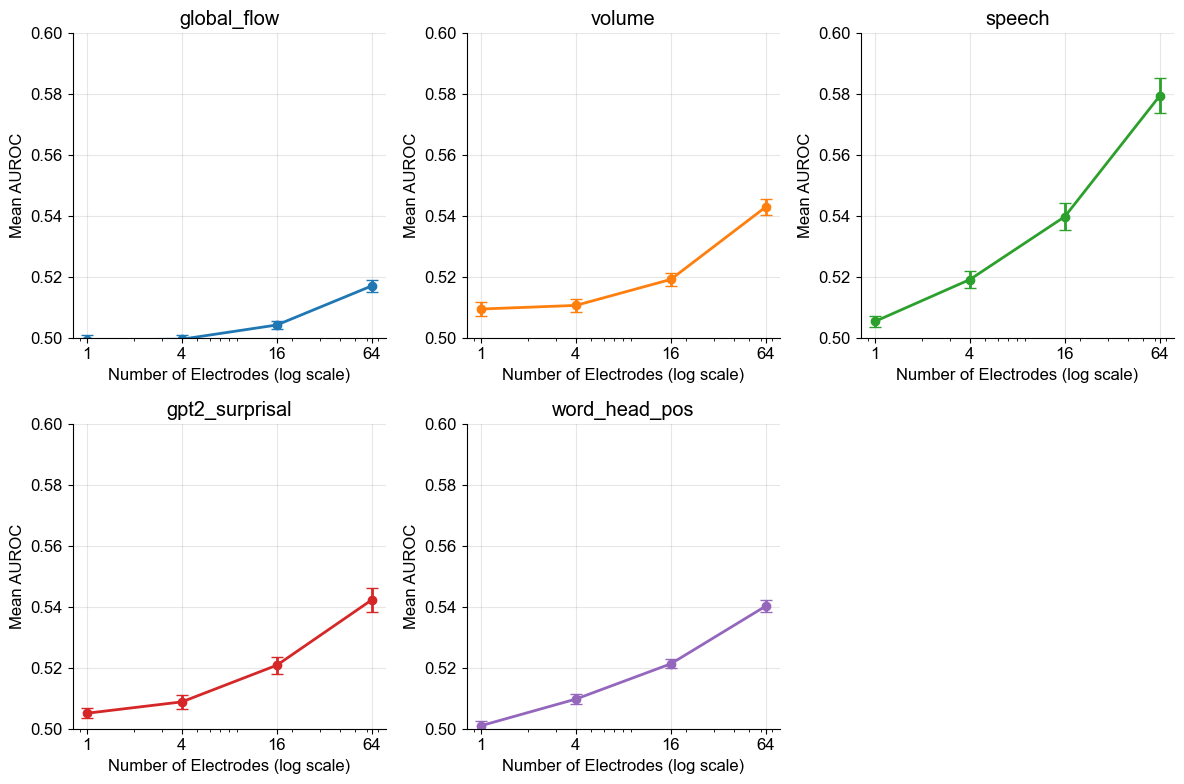

In [14]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import matplotlib.font_manager as fm
font_path = 'figures/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Define the evaluation names, preprocessing methods, and electrode subset sizes
eval_names = [
    "global_flow",
    "volume",
    "speech",
    "gpt2_surprisal",
    "word_head_pos",
    #"speaker"
]
preprocess_methods = ['none']  # Using raw voltage as specified in the script
n_electrode_subsets = [1, 4, 16, 64]
splits_type = "SS_DM"  # Same subject, different trial
seeds = [1001, 1002, 1003, 1004, 1005]

# Directory where results are stored
save_dir = f"eval_results_lite_{splits_type}_subsets"
file_pattern = f"{save_dir}/linear_voltage/*.json"

# Create a dictionary to store results for each evaluation
results_by_eval = {eval_name: {n: [] for n in n_electrode_subsets} for eval_name in eval_names}

# Find all result files
result_files = glob(file_pattern)
print(f"Found {len(result_files)} result files")

# Process each file
for file_path in result_files:
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Extract file name components to identify the evaluation
        filename = os.path.basename(file_path)
        parts = filename.split('_')
        
        # Extract evaluation name and electrode subset size
        eval_name = None
        n_electrodes = None
        
        for eval_candidate in eval_names:
            if eval_candidate in filename:
                eval_name = eval_candidate
                break
        
        if eval_name is None:
            continue
            
        # Find the electrode subset size (ne{number})
        for part in parts:
            if part.startswith('ne'):
                try:
                    n_electrodes = int(part[2:])
                    break
                except ValueError:
                    pass
        
        if n_electrodes not in n_electrode_subsets:
            continue
            
        # Extract the test ROC AUC from the one second after onset results
        if "evaluation_results" in data:
            for subject_trial, results in data["evaluation_results"].items():
                if "population" in results and "one_second_after_onset" in results["population"]:
                    bin_results = results["population"]["one_second_after_onset"]
                    if "folds" in bin_results:
                        # Calculate average test ROC AUC across folds
                        test_roc_aucs = [fold["test_roc_auc"] for fold in bin_results["folds"]]
                        avg_test_roc_auc = np.mean(test_roc_aucs)
                        results_by_eval[eval_name][n_electrodes].append(avg_test_roc_auc)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Calculate mean and standard error for each evaluation and electrode subset
summary_results = {}
for eval_name in eval_names:
    summary_results[eval_name] = {
        'mean': [],
        'se': [],
        'n_electrodes': []
    }
    
    for n_electrodes in n_electrode_subsets:
        values = results_by_eval[eval_name][n_electrodes]
        if values:
            mean_value = np.mean(values)
            se_value = np.std(values) / np.sqrt(len(values))
            summary_results[eval_name]['mean'].append(mean_value)
            summary_results[eval_name]['se'].append(se_value)
            summary_results[eval_name]['n_electrodes'].append(n_electrodes)
            print(f"{eval_name}, {n_electrodes} electrodes: Mean AUROC = {mean_value:.4f} ± {se_value:.4f} (n={len(values)})")
# Create a separate plot for each evaluation
plt.figure(figsize=(12, 8))
for i, eval_name in enumerate(eval_names):
    if not summary_results[eval_name]['mean']:
        continue
        
    plt.subplot(2, 3, i+1)
    plt.errorbar(
        summary_results[eval_name]['n_electrodes'],
        summary_results[eval_name]['mean'],
        yerr=summary_results[eval_name]['se'],
        marker='o',
        capsize=4,
        color=f'C{i}',
        linewidth=2
    )
    
    plt.xscale('log')
    plt.xlabel('Number of Electrodes (log scale)')
    # Set x-ticks at the actual electrode numbers
    plt.xticks(summary_results[eval_name]['n_electrodes'], 
               [str(n) for n in summary_results[eval_name]['n_electrodes']])
    plt.ylabel('Mean AUROC')
    plt.title(f'{eval_name}')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 0.6)
    
    # Set only left and bottom spines visible
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.tight_layout()
#plt.savefig(f'electrode_subset_performance_{splits_type}.pdf', dpi=300, bbox_inches='tight')
plt.show()


Processing global_flow...
  n_data=8: Mean AUROC = 0.5016 ± 0.0023 (N=60)
  n_data=32: Mean AUROC = 0.4986 ± 0.0022 (N=60)
  n_data=128: Mean AUROC = 0.5112 ± 0.0025 (N=60)
  n_data=512: Mean AUROC = 0.5213 ± 0.0020 (N=60)
Processing volume...
File eval_results_lite_SS_DM_subsets/linear_voltage/population_btbank10_0_nd8_seed1001_volume.json does not exist
  n_data=8: Mean AUROC = 0.5036 ± 0.0027 (N=59)
  n_data=32: Mean AUROC = 0.5105 ± 0.0023 (N=60)
  n_data=128: Mean AUROC = 0.5218 ± 0.0023 (N=60)
  n_data=512: Mean AUROC = 0.5413 ± 0.0030 (N=60)
Processing speech...
  n_data=8: Mean AUROC = 0.5028 ± 0.0043 (N=60)
  n_data=32: Mean AUROC = 0.5245 ± 0.0048 (N=60)
  n_data=128: Mean AUROC = 0.5567 ± 0.0050 (N=60)
  n_data=512: Mean AUROC = 0.5827 ± 0.0054 (N=60)
Processing gpt2_surprisal...
  n_data=8: Mean AUROC = 0.5041 ± 0.0028 (N=60)
  n_data=32: Mean AUROC = 0.5102 ± 0.0030 (N=60)
  n_data=128: Mean AUROC = 0.5270 ± 0.0030 (N=60)
  n_data=512: Mean AUROC = 0.5444 ± 0.0039 (N=60)
P

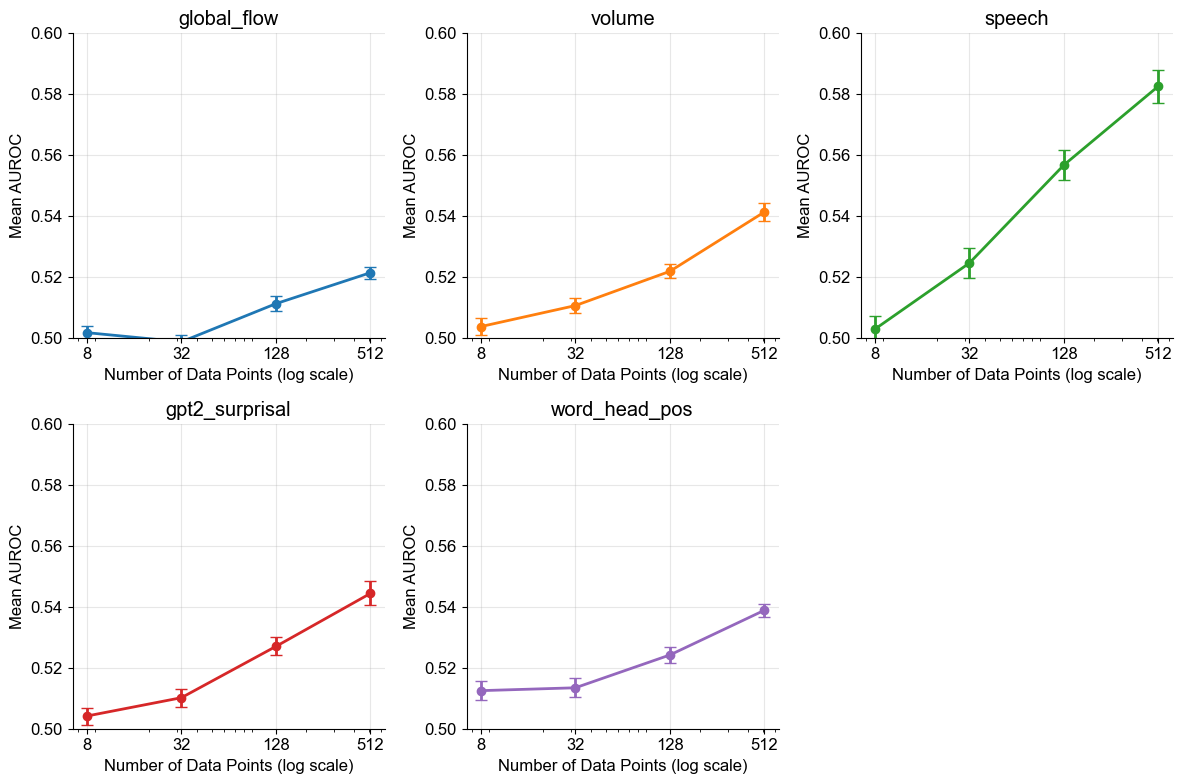

In [15]:
# Load and analyze data subset results
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Define parameters
splits_type = "SS_DM"  # Same subject, different trial
save_dir = f"eval_results_lite_{splits_type}_subsets"
preprocess = "none"  # Raw voltage
file_dir = f"{save_dir}/linear_{preprocess if preprocess != 'none' else 'voltage'}"

# Evaluation names to analyze (based on the bash script)
eval_names = [
    "global_flow",
    "volume",
    "speech",
    "gpt2_surprisal",
    "word_head_pos",
]

# Data subset sizes from the bash script
n_data_sizes = [8, 32, 128, 512]
seeds = [1001, 1002, 1003, 1004, 1005]

# Dictionary to store results for each evaluation
summary_results = defaultdict(lambda: {
    'n_data': [],
    'mean': [],
    'se': [],
    'individual_results': []
})

# Load results from files
for eval_name in eval_names:
    print(f"Processing {eval_name}...")
    
    for n_data in n_data_sizes:
        all_aurocs = []
        
        # Collect results across all subjects, trials, and seeds
        for seed in seeds:
            # Subjects and trials from the bash script
            subjects = [1, 1, 2, 2, 3, 3, 4, 4, 7, 7, 10, 10]
            trials = [1, 2, 0, 4, 0, 1, 0, 1, 0, 1, 0, 1]
            
            for subject, trial in zip(subjects, trials):
                file_path = f"{file_dir}/population_btbank{subject}_{trial}_nd{n_data}_seed{seed}_{eval_name}.json"
                
                if os.path.exists(file_path):
                    try:
                        with open(file_path, 'r') as f:
                            data = json.load(f)
                        
                        # Extract the one second after onset results
                        if "one_second_after_onset" in data["evaluation_results"][f"btbank{subject}_{trial}"]["population"]:
                            bin_results = data["evaluation_results"][f"btbank{subject}_{trial}"]["population"]["one_second_after_onset"]
                            
                            # Calculate average test ROC AUC across folds
                            fold_aurocs = [fold["test_roc_auc"] for fold in bin_results["folds"]]
                            avg_auroc = np.mean(fold_aurocs)
                            all_aurocs.append(avg_auroc)
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
                else:
                    print(f"File {file_path} does not exist")
        
        # Calculate mean and standard error if we have results
        if all_aurocs:
            mean_auroc = np.mean(all_aurocs)
            se_auroc = np.std(all_aurocs) / np.sqrt(len(all_aurocs))
            
            summary_results[eval_name]['n_data'].append(n_data)
            summary_results[eval_name]['mean'].append(mean_auroc)
            summary_results[eval_name]['se'].append(se_auroc)
            summary_results[eval_name]['individual_results'].append(all_aurocs)
            
            print(f"  n_data={n_data}: Mean AUROC = {mean_auroc:.4f} ± {se_auroc:.4f} (N={len(all_aurocs)})")

# Create a separate plot for each evaluation
plt.figure(figsize=(12, 8))
for i, eval_name in enumerate(eval_names):
    if not summary_results[eval_name]['mean']:
        continue
        
    plt.subplot(2, 3, i+1)
    plt.errorbar(
        summary_results[eval_name]['n_data'],
        summary_results[eval_name]['mean'],
        yerr=summary_results[eval_name]['se'],
        marker='o',
        capsize=4,
        color=f'C{i}',
        linewidth=2
    )
    
    plt.xscale('log')
    plt.xlabel('Number of Data Points (log scale)')
    # Set x-ticks at the actual data point numbers
    plt.xticks(summary_results[eval_name]['n_data'], 
               [str(n) for n in summary_results[eval_name]['n_data']])
    plt.ylabel('Mean AUROC')
    plt.title(f'{eval_name}')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 0.6)
    
    # Set only left and bottom spines visible
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.tight_layout()
#plt.savefig(f'data_subset_performance_{splits_type}.pdf', dpi=300, bbox_inches='tight')
plt.show()


Found 2771 result files
global_flow, 1 electrodes: Mean AUROC = 0.4993 ± 0.0017 (n=38)
global_flow, 4 electrodes: Mean AUROC = 0.4995 ± 0.0012 (n=58)
global_flow, 16 electrodes: Mean AUROC = 0.5042 ± 0.0012 (n=60)
global_flow, 64 electrodes: Mean AUROC = 0.5170 ± 0.0020 (n=60)
global_flow, 120 electrodes: Mean AUROC = 0.5100 ± 0.0011 (n=337)
volume, 1 electrodes: Mean AUROC = 0.5094 ± 0.0022 (n=38)
volume, 4 electrodes: Mean AUROC = 0.5106 ± 0.0022 (n=58)
volume, 16 electrodes: Mean AUROC = 0.5191 ± 0.0021 (n=60)
volume, 64 electrodes: Mean AUROC = 0.5429 ± 0.0027 (n=60)
volume, 120 electrodes: Mean AUROC = 0.5227 ± 0.0015 (n=336)
speech, 1 electrodes: Mean AUROC = 0.5053 ± 0.0018 (n=38)
speech, 4 electrodes: Mean AUROC = 0.5191 ± 0.0028 (n=58)
speech, 16 electrodes: Mean AUROC = 0.5398 ± 0.0043 (n=60)
speech, 64 electrodes: Mean AUROC = 0.5795 ± 0.0058 (n=60)
speech, 120 electrodes: Mean AUROC = 0.5465 ± 0.0028 (n=340)
gpt2_surprisal, 1 electrodes: Mean AUROC = 0.5051 ± 0.0017 (n=38)


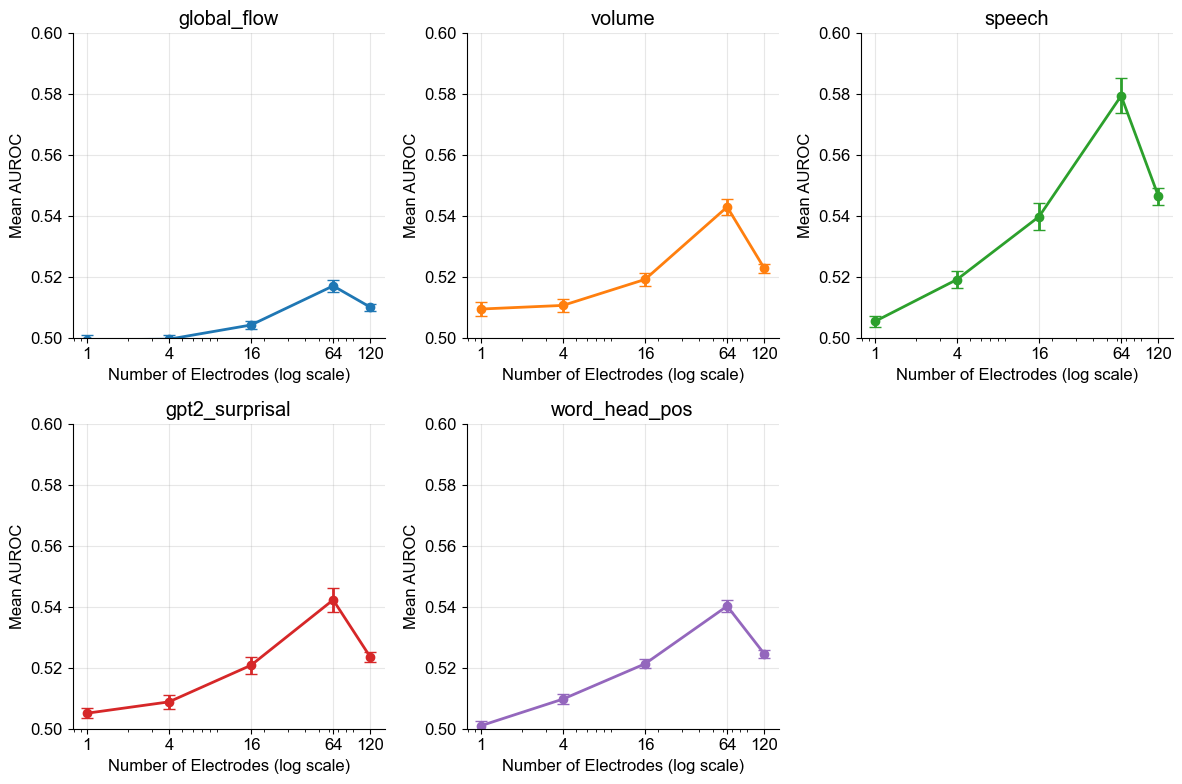

In [16]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import matplotlib.font_manager as fm
font_path = 'figures/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Define the evaluation names, preprocessing methods, and electrode subset sizes
eval_names = [
    "global_flow",
    "volume",
    "speech",
    "gpt2_surprisal",
    "word_head_pos",
    #"speaker"
]
preprocess_methods = ['none']  # Using raw voltage as specified in the script
n_electrode_subsets = [1, 4, 16, 64]
splits_type = "SS_DM"  # Same subject, different trial
seeds = [1001, 1002, 1003, 1004, 1005]

# Directory where results are stored
save_dir = f"eval_results_lite_{splits_type}_subsets"
file_pattern = f"{save_dir}/linear_voltage/*.json"

# Create a dictionary to store results for each evaluation
results_by_eval = {eval_name: {n: [] for n in n_electrode_subsets + [120]} for eval_name in eval_names}

# Find all result files
result_files = glob(file_pattern)
print(f"Found {len(result_files)} result files")

# Process each file
for file_path in result_files:
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Extract file name components to identify the evaluation
        filename = os.path.basename(file_path)
        parts = filename.split('_')
        
        # Extract evaluation name and electrode subset size
        eval_name = None
        n_electrodes = None
        
        for eval_candidate in eval_names:
            if eval_candidate in filename:
                eval_name = eval_candidate
                break
        
        if eval_name is None:
            continue
            
        # Find the electrode subset size (ne{number})
        for part in parts:
            if part.startswith('ne'):
                try:
                    n_electrodes = int(part[2:])
                    break
                except ValueError:
                    pass
        
        # If no ne{number} found, check if this is a regular file (full electrode set = 120)
        if n_electrodes is None and "population" in filename:
            n_electrodes = 120
        
        if n_electrodes not in n_electrode_subsets + [120]:
            continue
            
        # Extract the test ROC AUC from the one second after onset results
        if "evaluation_results" in data:
            for subject_trial, results in data["evaluation_results"].items():
                if "population" in results and "one_second_after_onset" in results["population"]:
                    bin_results = results["population"]["one_second_after_onset"]
                    if "folds" in bin_results:
                        # Calculate average test ROC AUC across folds
                        test_roc_aucs = [fold["test_roc_auc"] for fold in bin_results["folds"]]
                        avg_test_roc_auc = np.mean(test_roc_aucs)
                        results_by_eval[eval_name][n_electrodes].append(avg_test_roc_auc)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Calculate mean and standard error for each evaluation and electrode subset
summary_results = {}
for eval_name in eval_names:
    summary_results[eval_name] = {
        'mean': [],
        'se': [],
        'n_electrodes': []
    }
    
    for n_electrodes in n_electrode_subsets + [120]:
        values = results_by_eval[eval_name][n_electrodes]
        if values:
            mean_value = np.mean(values)
            se_value = np.std(values) / np.sqrt(len(values))
            summary_results[eval_name]['mean'].append(mean_value)
            summary_results[eval_name]['se'].append(se_value)
            summary_results[eval_name]['n_electrodes'].append(n_electrodes)
            print(f"{eval_name}, {n_electrodes} electrodes: Mean AUROC = {mean_value:.4f} ± {se_value:.4f} (n={len(values)})")

# Create a separate plot for each evaluation
plt.figure(figsize=(12, 8))
for i, eval_name in enumerate(eval_names):
    if not summary_results[eval_name]['mean']:
        continue
        
    plt.subplot(2, 3, i+1)
    plt.errorbar(
        summary_results[eval_name]['n_electrodes'],
        summary_results[eval_name]['mean'],
        yerr=summary_results[eval_name]['se'],
        marker='o',
        capsize=4,
        color=f'C{i}',
        linewidth=2
    )
    
    plt.xscale('log')
    plt.xlabel('Number of Electrodes (log scale)')
    # Set x-ticks at the actual electrode numbers
    plt.xticks(summary_results[eval_name]['n_electrodes'], 
               [str(n) for n in summary_results[eval_name]['n_electrodes']])
    plt.ylabel('Mean AUROC')
    plt.title(f'{eval_name}')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 0.6)
    
    # Set only left and bottom spines visible
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.tight_layout()
#plt.savefig(f'electrode_subset_performance_{splits_type}.pdf', dpi=300, bbox_inches='tight')
plt.show()
